In [1]:
import re    # for regular expressions  
import string 
import warnings 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt  

pd.set_option("display.max_colwidth", 200) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline

In [2]:
import json
import csv
import nltk
import tweepy
from sklearn import metrics
import re
import os
from nltk.corpus import stopwords
from keras.layers import Dense, Dropout, Activation
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim
from tqdm import tqdm 
tqdm.pandas(desc="progress-bar") 
from gensim.models.doc2vec import TaggedDocument

Using TensorFlow backend.
D:\Important\Anaconda\envs\NLP\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Important\Anaconda\envs\NLP\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Important\Anaconda\envs\NLP\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Important\Anaconda\envs\NLP\lib\site-packages\tensorflow\py

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Dropout , Activation, Flatten, SimpleRNN
from keras.layers import GlobalMaxPool1D
from keras.models import Model, Sequential
import tensorflow as tf

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
df1 = pd.read_csv('final_data.csv')

In [5]:
df1.head(0)

,Unnamed: 0,tweet_id,timestamp,user_id,text,hashtags,sentiment


In [6]:
df1['split'] = np.random.randn(df1.shape[0], 1)

msk = np.random.rand(len(df1)) <= 0.7

train_1 = df1[msk]
test_1 = df1[~msk]

In [7]:
train_1.to_csv('final_train.csv', encoding='utf-8')

In [8]:
test_1.to_csv('final_test.csv', encoding='utf-8')

In [9]:
train  = pd.read_csv('final_train.csv') 
test = pd.read_csv('final_test.csv')

In [10]:
train.drop(train.columns[[0,1]], axis=1, inplace=True)

In [11]:
test.drop(test.columns[[0,1]], axis=1, inplace=True)

## Exploring Data

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11298 entries, 0 to 11297
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   11298 non-null  float64
 1   timestamp  11298 non-null  object 
 2   user_id    11298 non-null  float64
 3   text       11298 non-null  object 
 4   hashtags   11298 non-null  object 
 5   sentiment  11298 non-null  int64  
 6   split      11298 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 618.0+ KB


In [13]:
test.head()

,tweet_id,timestamp,user_id,text,hashtags,sentiment,split
0,1.460000e+18,2021-11-07T23:59:15+00:00,3.380000e+09,.@Pfizer will rake in billions from its expensive #CovidVaccine but @AlbertBourla refuses to cut the price for lowe… https://t.co/eC94w3TUl0,['CovidVaccine'],-1,-0.089067
1,1.460000e+18,2021-11-07T20:15:02+00:00,3.228971e+07,"Wear a mask, wash your hands, and remain socially distant when possible. #stayhome #StayAtHome #StayAtHomeSaveLives… https://t.co/Jrlrg6bm0w","['stayhome', 'StayAtHome', 'StayAtHomeSaveLives']",0,0.331552
2,1.460000e+18,2021-11-07T19:27:55+00:00,3.030000e+08,⁦@AvgerinosMoscow⁩ #PfizerBioNTech #FDA approval Apprentice Style!\n⁦@realDonaldTrump⁩: “Approve the #vaccine or you… https://t.co/f64cOP5DV6,"['PfizerBioNTech', 'FDA', 'vaccine']",1,-0.053970
3,1.460000e+18,2021-11-07T14:25:27+00:00,2.484300e+07,An immigrant Muslim couple find the COVID-19 Vaccine. \n\n#CovidVaccine #PfizerBioNTech #Pfizervaccine #PfizerProud,"['CovidVaccine', 'PfizerBioNTech', 'Pfizervaccine', 'PfizerProud']",0,0.848521
4,1.460000e+18,2021-11-07T13:37:15+00:00,7.100000e+17,@mirekR9 @sputnikvaccine @AstraZeneca it's the only one which doesn't have any side effects \n\nthe #PfizerBioNTech a… https://t.co/IWELAATAmd,['PfizerBioNTech'],0,-0.225347


In [14]:
train.shape, test.shape

((11298, 7), (4882, 7))

In [15]:
train["sentiment"].value_counts()

 0    5499
 1    4055
-1    1744
Name: sentiment, dtype: int64

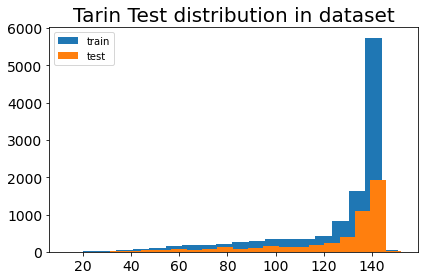

In [16]:
plt.hist(train.text.str.len(), bins=20, label='train')
plt.hist(test.text.str.len(), bins=20, label='test')
plt.legend()
plt.title('Tarin Test distribution in dataset', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.tight_layout()
plt.tight_layout()
plt.savefig("Train Test Distribution.png", dpi=200, bbox_inches='tight')

In [17]:
combi = train.append(test, ignore_index=True, sort=True)
combi.shape

(16180, 7)

In [18]:
combi['sentiment'].replace({1: 2, 0: 1, -1: 0}, inplace=True)

In [19]:
combi["sentiment"].value_counts()

1    7865
2    5770
0    2545
Name: sentiment, dtype: int64

In [20]:
combi.drop(combi.columns[[6]], axis=1, inplace=True)

Number of rows per vaccine rating:
1    7865
2    5770
0    2545
Name: sentiment, dtype: int64


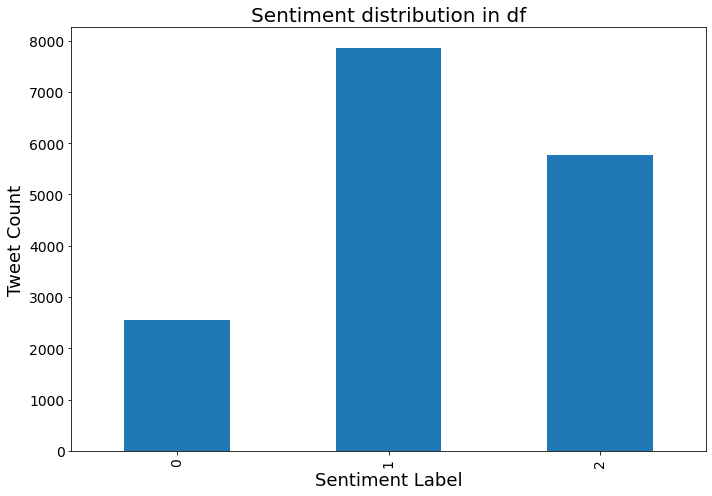

In [21]:
print("Number of rows per vaccine rating:")
print(combi['sentiment'].value_counts())
plt.figure(figsize=(10, 7)) 
combi['sentiment'].value_counts().sort_index().plot.bar()
plt.title('Sentiment distribution in df', fontsize=20)
plt.xlabel('Sentiment Label', fontsize=18)
plt.ylabel('Tweet Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.tight_layout()
plt.savefig("Sentiment_Distribution.png", dpi=200, bbox_inches='tight')

## Data Wrangling & Preprocessing
### Remove Punctuation: (a)hashtags (b)links (c)punctuations (d)non-alphanumeric characters

In [22]:
def preprocess_word(word):
    word = word.lower()
    word = re.sub("'", "", word)
    word = word.strip('\'"?!,.():;')
    word = re.sub(r'(.)\1+', r'\1\1', word)
    word = re.sub("@[A-Za-z0-9_]+","", word)
    word = re.sub("#[A-Za-z0-9_]+","", word)
    word = re.sub(r'http\S+', '', word)
    word = re.sub("[^a-z0-9]"," ", word)
    word = re.sub('\[.*?\]',' ', word)
    word = re.sub(r'(-|\')', '', word)
    return word

In [23]:
combi['tidy_tweet'] = combi['text'].apply(preprocess_word)
combi.head()

,hashtags,sentiment,split,text,timestamp,tweet_id,tidy_tweet
0,['PfizerBioNTech'],2,1.038622,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,2021-11-08T03:49:15+00:00,1.460000e+18,same folks said daikon paste could treat a cytokine storm
1,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",2,-0.450094,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,2021-11-08T02:00:44+00:00,1.460000e+18,russian vaccine is created to last 2 4 years
2,['vaccination'],2,0.117162,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",2021-11-08T01:43:37+00:00,1.460000e+18,it is a bit sad to claim the fame for success of on patriotic competition between usa canada uk and
3,"['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",1,0.581711,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",2021-11-08T01:40:23+00:00,1.460000e+18,states will start getting monday says
4,"['PfizerBioNTech', 'Vaccine']",1,-0.444087,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP",2021-11-08T01:36:25+00:00,1.460000e+18,while deaths are closing in on the 300 00 mark millions of people wait the first u


## Stop word removal

In [24]:
stopwords = nltk.corpus.stopwords.words('english')
combi['tidy_tweet'].apply(lambda x: [item for item in x if item not in stopwords])

0                                                                                                                 [e,  , f, l, k,  ,  , k, n,  , p, e,  , c, u, l,  , r, e,  ,  , c, k, n, e,  , r,  ,  ]
1                                                                                                     [ ,  ,  ,  ,  ,  , r, u, n,  , v, c, c, n, e,  ,  , c, r, e, e,  ,  , l,  , 2,  , 4,  , e, r,  ,  ]
2                          [ ,  ,  , b,  ,  ,  , c, l,  , h, e,  , f, e,  , f, r,  , u, c, c, e,  , f,  ,  , n,  , p, r, c,  , c, p, e, n,  , b, e, w, e, e, n,  , u,  ,  , c, n,  ,  , u, k,  , n,  ,  ]
3                                                                                                                    [ ,  ,  , e,  , w, l, l,  , r,  , g, e, n, g,  ,  , n,  ,  ,  ,  ,  ,  ,  ,  ,  ,  ]
4        [w, h, l, e,  , e, h,  , r, e,  , c, l, n, g,  , n,  , n,  , h, e,  , 3, 0, 0,  , 0, 0,  , r, k,  ,  ,  , l, l, n,  , f,  , p, e, p, l, e,  , w,  ,  ,  ,  ,  ,  ,  , h, e,  , f, r,  ,

In [25]:
combi.head()

,hashtags,sentiment,split,text,timestamp,tweet_id,tidy_tweet
0,['PfizerBioNTech'],2,1.038622,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,2021-11-08T03:49:15+00:00,1.460000e+18,same folks said daikon paste could treat a cytokine storm
1,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",2,-0.450094,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,2021-11-08T02:00:44+00:00,1.460000e+18,russian vaccine is created to last 2 4 years
2,['vaccination'],2,0.117162,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",2021-11-08T01:43:37+00:00,1.460000e+18,it is a bit sad to claim the fame for success of on patriotic competition between usa canada uk and
3,"['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",1,0.581711,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",2021-11-08T01:40:23+00:00,1.460000e+18,states will start getting monday says
4,"['PfizerBioNTech', 'Vaccine']",1,-0.444087,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP",2021-11-08T01:36:25+00:00,1.460000e+18,while deaths are closing in on the 300 00 mark millions of people wait the first u


## Handle Emojis

In [26]:
def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet

In [27]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(handle_emojis)
combi.head()

,hashtags,sentiment,split,text,timestamp,tweet_id,tidy_tweet
0,['PfizerBioNTech'],2,1.038622,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,2021-11-08T03:49:15+00:00,1.460000e+18,same folks said daikon paste could treat a cytokine storm
1,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",2,-0.450094,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,2021-11-08T02:00:44+00:00,1.460000e+18,russian vaccine is created to last 2 4 years
2,['vaccination'],2,0.117162,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",2021-11-08T01:43:37+00:00,1.460000e+18,it is a bit sad to claim the fame for success of on patriotic competition between usa canada uk and
3,"['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",1,0.581711,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",2021-11-08T01:40:23+00:00,1.460000e+18,states will start getting monday says
4,"['PfizerBioNTech', 'Vaccine']",1,-0.444087,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP",2021-11-08T01:36:25+00:00,1.460000e+18,while deaths are closing in on the 300 00 mark millions of people wait the first u


## Fix Bad Unicode

In [28]:
def fix_bad_unicode(text, normalization="NFC"):
    try:
        text = text.encode("latin", "backslashreplace").decode("unicode-escape")
    except:
        pass

    return fix_text(text, normalization=normalization)

In [29]:
combi['tidy_tweet'] = combi['tidy_tweet'].apply(handle_emojis)
combi.head()

,hashtags,sentiment,split,text,timestamp,tweet_id,tidy_tweet
0,['PfizerBioNTech'],2,1.038622,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,2021-11-08T03:49:15+00:00,1.460000e+18,same folks said daikon paste could treat a cytokine storm
1,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",2,-0.450094,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,2021-11-08T02:00:44+00:00,1.460000e+18,russian vaccine is created to last 2 4 years
2,['vaccination'],2,0.117162,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",2021-11-08T01:43:37+00:00,1.460000e+18,it is a bit sad to claim the fame for success of on patriotic competition between usa canada uk and
3,"['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",1,0.581711,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",2021-11-08T01:40:23+00:00,1.460000e+18,states will start getting monday says
4,"['PfizerBioNTech', 'Vaccine']",1,-0.444087,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP",2021-11-08T01:36:25+00:00,1.460000e+18,while deaths are closing in on the 300 00 mark millions of people wait the first u


## Remove Pattern

In [30]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [31]:
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tidy_tweet'], "@[\w]*") 
combi.head()

,hashtags,sentiment,split,text,timestamp,tweet_id,tidy_tweet
0,['PfizerBioNTech'],2,1.038622,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,2021-11-08T03:49:15+00:00,1.460000e+18,same folks said daikon paste could treat a cytokine storm
1,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",2,-0.450094,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,2021-11-08T02:00:44+00:00,1.460000e+18,russian vaccine is created to last 2 4 years
2,['vaccination'],2,0.117162,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",2021-11-08T01:43:37+00:00,1.460000e+18,it is a bit sad to claim the fame for success of on patriotic competition between usa canada uk and
3,"['CovidVaccine', 'COVID19Vaccine', 'US', 'pakustv', 'NYC', 'Healthcare', 'GlobalGoals']",1,0.581711,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",2021-11-08T01:40:23+00:00,1.460000e+18,states will start getting monday says
4,"['PfizerBioNTech', 'Vaccine']",1,-0.444087,"while deaths are closing in on the 300,000 mark... millions of people wait #PfizerBioNTech #Vaccine !\n-\nThe first U… https://t.co/uQ3A2f7SVP",2021-11-08T01:36:25+00:00,1.460000e+18,while deaths are closing in on the 300 00 mark millions of people wait the first u


## Wordclouds

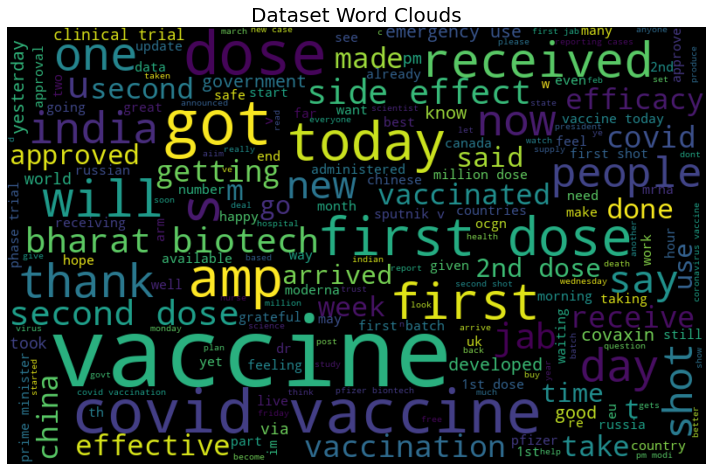

In [32]:
all_words = ' '.join([text for text in combi['tidy_tweet']]) 
# fig = plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off')
plt.title('Dataset Word Clouds', fontsize=20)
# plt.show()
plt.tight_layout()
plt.savefig("Word_Clouds.png", dpi=200, bbox_inches='tight')


# normal_words =' '.join([text for text in combi['tidy_tweet'][combi['sentiment'] == 1]]) 

# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
# plt.figure(figsize=(10, 7))
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis('off')
# plt.title('Neutral Word Clouds', fontsize=20)
# # plt.show()
# plt.tight_layout()
# plt.savefig("Neutral_Word_Clouds.png", dpi=200, bbox_inches='tight')

## Neutral Sentiment Words

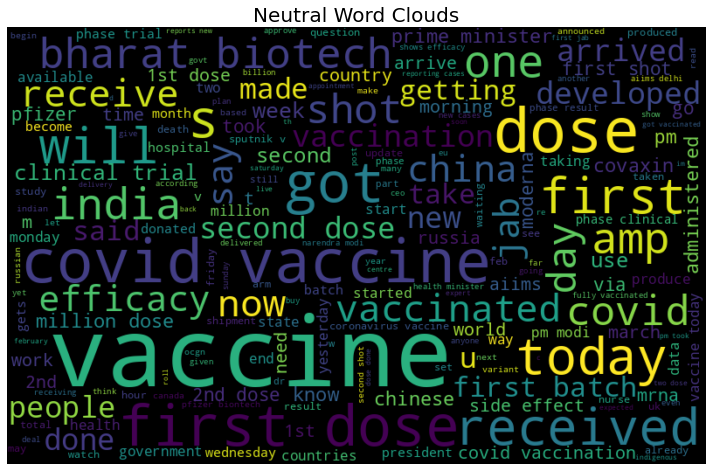

In [33]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['sentiment'] == 1]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Neutral Word Clouds', fontsize=20)
# plt.show()
plt.tight_layout()
plt.savefig("Neutral_Word_Clouds.png", dpi=200, bbox_inches='tight')

## Positive Sentiment Words

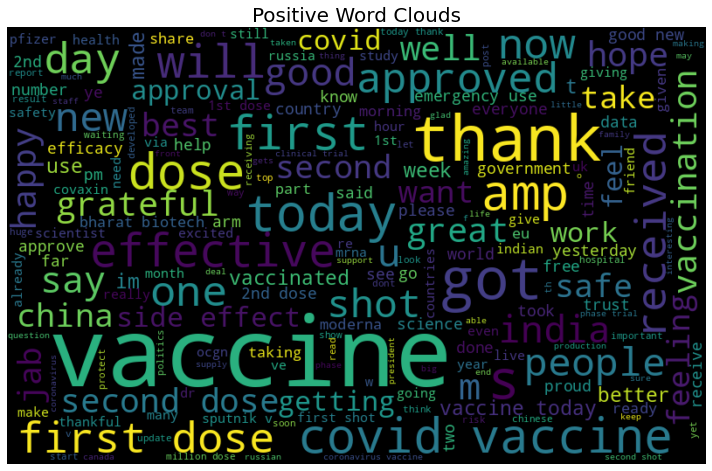

In [34]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['sentiment'] == 2]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Positive Word Clouds', fontsize=20)
# plt.show()
plt.tight_layout()
plt.savefig("Positive_Word_Clouds.png", dpi=200, bbox_inches='tight')

In [35]:
combi['sentiment'].value_counts()

1    7865
2    5770
0    2545
Name: sentiment, dtype: int64

## Negative Sentiment Words

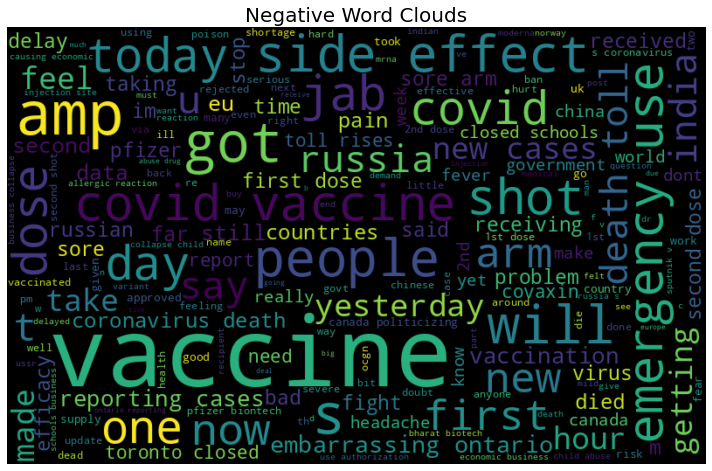

In [36]:
normal_words =' '.join([text for text in combi['tidy_tweet'][combi['sentiment'] == 0]]) 

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Negative Word Clouds', fontsize=20)
# plt.show()
plt.tight_layout()
plt.savefig("Negative_Word_Clouds.png", dpi=200, bbox_inches='tight')

## Impact on Hashtags

In [37]:
def hashtag_extract(x):
    hashtags = []    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags

In [38]:
HT_neutral = hashtag_extract(combi['text'][combi['sentiment'] == 1])

In [39]:
HT_positive = hashtag_extract(combi['text'][combi['sentiment'] == 2]) 

In [40]:
HT_negative = hashtag_extract(combi['text'][combi['sentiment'] == 0])

In [41]:
HT_neutral = sum(HT_neutral,[]) 
HT_positive = sum(HT_positive,[])
HT_negative = sum(HT_negative,[])

In [42]:
len(HT_negative)

5411

## Neutral Sentiment Hashtags

In [43]:
a = nltk.FreqDist(HT_neutral)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
)

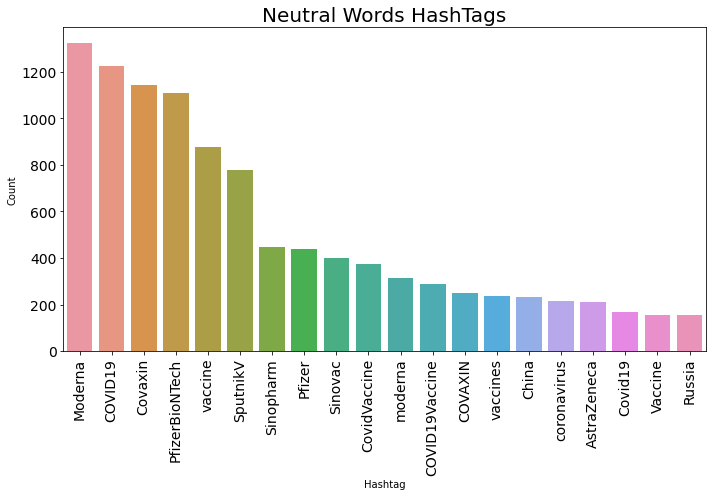

In [44]:
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(10,7))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.title('Neutral Words HashTags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.tight_layout()
plt.savefig("Neutral_Word_Hashtags.png", dpi=200, bbox_inches='tight')

## Positive Sentiment Hashtags

In [45]:
a = nltk.FreqDist(HT_positive)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
)

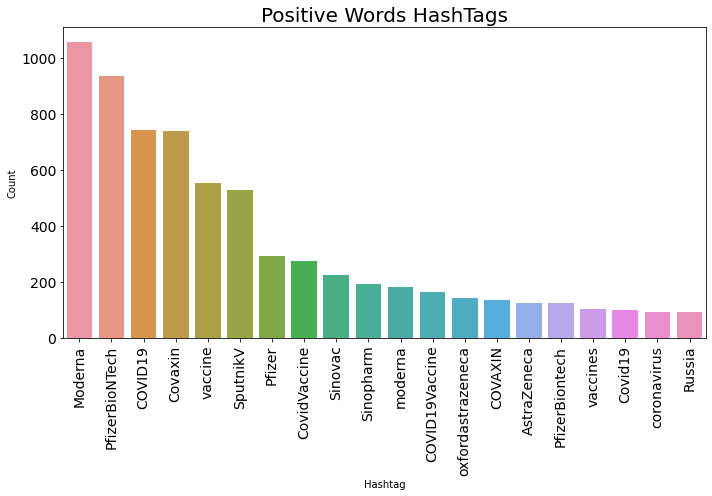

In [46]:
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(10,7))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.xticks(rotation=90)
plt.title('Positive Words HashTags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.tight_layout()
plt.savefig("Positive_Word_Hashtags.png", dpi=200, bbox_inches='tight')

## Negative Sentiment Hashtags

In [47]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame(
    {
    'Hashtag': list(a.keys()),
    'Count': list(a.values())
    }
)

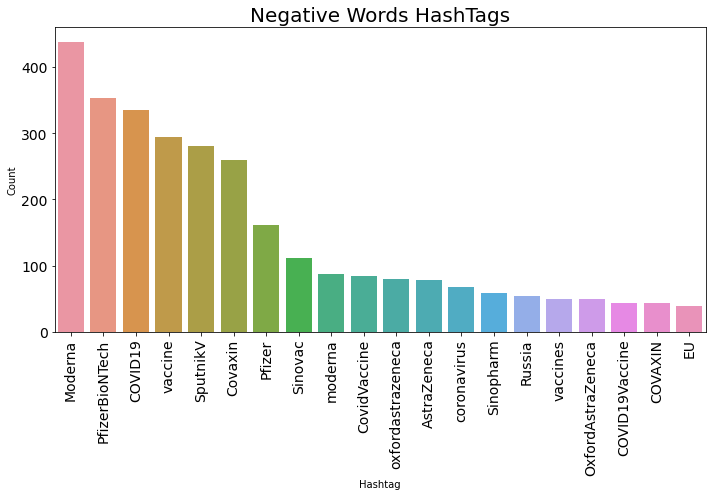

In [48]:
d = d.nlargest(columns="Count", n = 20)
plt.figure(figsize=(10,7))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
plt.xticks(rotation=90)
plt.title('Negative Words HashTags', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.show()
plt.tight_layout()
plt.savefig("Negative_Word_Hashtags.png", dpi=200, bbox_inches='tight')

## Bag-of-Words Features

## Build a Classification Model

In [49]:
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])
bow.shape

(16180, 1000)

## TF-IDF Features

In [50]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf.shape

(16180, 1000)

## Word2Vec Features

In [51]:
%%time

tokenized_tweet = combi['tidy_tweet'].apply(lambda x: x.split()) # tokenizing 

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            vector_size=500, # desired no. of features/independent variables
            window=5, # context window size
            min_count=2, # Ignores all words with total frequency lower than 2.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 32, # no.of cores
            seed = 34
)

model_w2v.train(tokenized_tweet, total_examples= len(combi['tidy_tweet']), epochs=20)

Wall time: 17.6 s


In [52]:
model_w2v.wv.most_similar(positive="fever")

[('chills', 0.7706041932106018),
 ('throat', 0.720107913017273),
 ('pains', 0.7176342606544495),
 ('aches', 0.7100859880447388),
 ('beside', 0.7086047530174255),
 ('restless', 0.7069007754325867),
 ('rigors', 0.6999502182006836),
 ('nausea', 0.6992307305335999),
 ('malaise', 0.6987523436546326),
 ('headache', 0.698096513748169)]

In [53]:
model_w2v.wv.most_similar(positive="throat")

[('achey', 0.8986748456954956),
 ('feverish', 0.8964230418205261),
 ('joints', 0.8921777606010437),
 ('tenderness', 0.8894975781440735),
 ('nausea', 0.8790697455406189),
 ('mildly', 0.8787042498588562),
 ('queasy', 0.8761879205703735),
 ('muscles', 0.8702207207679749),
 ('rigors', 0.8619417548179626),
 ('fatigued', 0.8557345867156982)]

In [54]:
model_w2v.wv['moderna']

array([-0.15061143, -0.00874774, -0.15450773, -0.10212237, -0.23760189,
       -0.1729361 ,  0.3938283 ,  0.11183991, -0.07812409,  0.00287259,
        0.07239857, -0.07354222,  0.1467992 ,  0.17867127,  0.21519774,
       -0.2206108 ,  0.10297523,  0.11931697,  0.15793784,  0.4440082 ,
        0.07199913,  0.04665896,  0.2616949 ,  0.10704853,  0.16758177,
        0.28677228, -0.09952451,  0.15820739, -0.23703918,  0.03498949,
        0.40318367,  0.09517463, -0.01127555,  0.17431636, -0.17922784,
        0.05251551, -0.02661835, -0.18478586,  0.12091374,  0.09291701,
       -0.40476397, -0.09924559, -0.10318086,  0.05523995,  0.1789633 ,
        0.03199775,  0.06423504, -0.1868073 ,  0.5098891 ,  0.24480969,
       -0.15691386, -0.00687465,  0.31903523,  0.20075224, -0.04818113,
        0.65975064, -0.4264927 ,  0.08452982,  0.2887728 ,  0.01589383,
       -0.3987797 ,  0.09245475,  0.14867596, -0.35858026, -0.03571276,
        0.02299972, -0.22883198,  0.22889607, -0.09389444, -0.09

In [55]:
len(model_w2v.wv['moderna'])

500

## Preparing Vectors for Tweets

In [56]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

## Preparing Word2Vec Feature Set

In [57]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 500)) 
for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 500)
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape

(16180, 500)

## Doc2Vec Embedding

In [58]:
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(TaggedDocument(s, ["tweet_" + str(i)]))
    return output

labeled_tweets = add_label(tokenized_tweet) # label all the tweets

In [59]:
labeled_tweets[:6]

[TaggedDocument(words=['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'a', 'cytokine', 'storm'], tags=['tweet_0']),
 TaggedDocument(words=['russian', 'vaccine', 'is', 'created', 'to', 'last', '2', '4', 'years'], tags=['tweet_1']),
 TaggedDocument(words=['it', 'is', 'a', 'bit', 'sad', 'to', 'claim', 'the', 'fame', 'for', 'success', 'of', 'on', 'patriotic', 'competition', 'between', 'usa', 'canada', 'uk', 'and'], tags=['tweet_2']),
 TaggedDocument(words=['states', 'will', 'start', 'getting', 'monday', 'says'], tags=['tweet_3']),
 TaggedDocument(words=['while', 'deaths', 'are', 'closing', 'in', 'on', 'the', '300', '00', 'mark', 'millions', 'of', 'people', 'wait', 'the', 'first', 'u'], tags=['tweet_4']),
 TaggedDocument(words=['trump', 'announces', 'rollout', 'in', 'less', 'than', '24', 'hours', 'the', 'first', 'americans', 'will', 'be', 'vaccinated', 'against'], tags=['tweet_5'])]

In [60]:
%%time 
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model
                                  dm_mean=1, # dm_mean = 1 for using mean of the context word vectors
                                  vector_size=500, # no. of desired features
                                  window=5, # width of the context window                                  
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 5.                                  
                                  workers=32, # no. of cores                                  
                                  alpha=0.1, # learning rate                                  
                                  seed = 23, # for reproducibility
                                 ) 

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

model_d2v.train(labeled_tweets, total_examples= len(combi['tidy_tweet']), epochs=15)

100%|██████████| 16180/16180 [00:00<00:00, 951540.08it/s]


Wall time: 27.1 s


In [61]:
docvec_arrays = np.zeros((len(tokenized_tweet), 500)) 
for i in range(len(combi)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,500))    

docvec_df = pd.DataFrame(docvec_arrays) 
docvec_df.shape

(16180, 500)

In [62]:
# Extracting train and test BoW features 
train_bow = bow[:16180,:]

# splitting data into training and validation set 
x_train,x_test,y_train,y_test = train_test_split(train_bow, combi['sentiment'], random_state=42, test_size=0.3)

In [63]:
type(train_bow)

scipy.sparse.csr.csr_matrix

## Machine Learning for CounterVectorization

## SVC

In [64]:
svc_model = LinearSVC(class_weight='balanced',C=1, penalty='l2', max_iter=1500,loss='squared_hinge',
                        multi_class='ovr').fit(x_train, y_train)

svc_model_predict = svc_model.predict(x_test)
svc_report = classification_report(y_test, svc_model_predict )

print(svc_report)

              precision    recall  f1-score   support

           0       0.59      0.49      0.53       769
           1       0.78      0.90      0.84      2403
           2       0.86      0.75      0.80      1682

    accuracy                           0.78      4854
   macro avg       0.75      0.71      0.72      4854
weighted avg       0.78      0.78      0.78      4854



## SGDClassifier

In [65]:
sgd_model = SGDClassifier(n_jobs=-1,class_weight='balanced',penalty='l2').fit(x_train, y_train)
sgd_model_predict = sgd_model.predict(x_test)
sgd_report = classification_report(y_test, sgd_model_predict )

print(sgd_report)

              precision    recall  f1-score   support

           0       0.66      0.47      0.55       769
           1       0.78      0.94      0.85      2403
           2       0.89      0.75      0.81      1682

    accuracy                           0.80      4854
   macro avg       0.78      0.72      0.74      4854
weighted avg       0.80      0.80      0.79      4854



## MLPClassifier

In [66]:
mlp = MLPClassifier().fit(x_train, y_train)
mlp_predict = mlp.predict(x_test)
mlp_report = classification_report(y_test, mlp_predict )
print(mlp_report)

              precision    recall  f1-score   support

           0       0.57      0.49      0.53       769
           1       0.80      0.84      0.82      2403
           2       0.78      0.77      0.77      1682

    accuracy                           0.76      4854
   macro avg       0.72      0.70      0.71      4854
weighted avg       0.76      0.76      0.76      4854



## KNeighborsClassifier

In [67]:
classifier = KNeighborsClassifier(n_neighbors=5,algorithm='brute') 
classifier.fit(x_train, y_train) 
predicted_label = classifier.predict(x_test) 
knn_model_report = classification_report(y_test, predicted_label)
print(knn_model_report)

              precision    recall  f1-score   support

           0       0.44      0.25      0.32       769
           1       0.58      0.93      0.72      2403
           2       0.85      0.29      0.44      1682

    accuracy                           0.60      4854
   macro avg       0.62      0.49      0.49      4854
weighted avg       0.65      0.60      0.56      4854



## RandomForestClassifier

In [68]:
rf = RandomForestClassifier(n_estimators=100).fit(x_train, y_train)
rf_predict = rf.predict(x_test)
rf_report = classification_report(y_test, rf_predict )
print(rf_report)

              precision    recall  f1-score   support

           0       0.64      0.45      0.53       769
           1       0.78      0.90      0.83      2403
           2       0.82      0.75      0.79      1682

    accuracy                           0.78      4854
   macro avg       0.75      0.70      0.72      4854
weighted avg       0.77      0.78      0.77      4854



## AdaBoostClassifier

In [69]:
ab = AdaBoostClassifier(n_estimators=100, learning_rate=1).fit(x_train, y_train)
ab_predict = ab.predict(x_test)
ab_report = classification_report(y_test, ab_predict )
print(ab_report)

              precision    recall  f1-score   support

           0       0.87      0.37      0.52       769
           1       0.72      0.98      0.83      2403
           2       0.90      0.66      0.76      1682

    accuracy                           0.77      4854
   macro avg       0.83      0.67      0.70      4854
weighted avg       0.80      0.77      0.75      4854



## BaggingClassifier

In [70]:
bagging = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(x_train, y_train)
bagging_predict = bagging.predict(x_test)
bagging_report = classification_report(y_test, bagging_predict )
print(bagging_report)

              precision    recall  f1-score   support

           0       0.80      0.36      0.50       769
           1       0.74      0.96      0.84      2403
           2       0.87      0.73      0.79      1682

    accuracy                           0.78      4854
   macro avg       0.80      0.68      0.71      4854
weighted avg       0.80      0.78      0.77      4854



## ExtraTreesClassifier

In [71]:
et = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
et_predict = et.predict(x_test)
et_report = classification_report(y_test, et_predict)
print(et_report)

              precision    recall  f1-score   support

           0       0.61      0.48      0.53       769
           1       0.79      0.86      0.83      2403
           2       0.80      0.77      0.78      1682

    accuracy                           0.77      4854
   macro avg       0.73      0.70      0.72      4854
weighted avg       0.76      0.77      0.77      4854



## DecisionTreeClassifier

In [72]:
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
dt_model_report = classification_report(y_test, y_pred)
print(dt_model_report)

              precision    recall  f1-score   support

           0       0.49      0.49      0.49       769
           1       0.79      0.81      0.80      2403
           2       0.76      0.74      0.75      1682

    accuracy                           0.73      4854
   macro avg       0.68      0.68      0.68      4854
weighted avg       0.73      0.73      0.73      4854



## Logistic Regression

In [73]:
logistic_reg_model = LogisticRegression(n_jobs = -1, penalty='l2', multi_class='multinomial',class_weight = 'balanced',verbose=1).fit(x_train,y_train)

lr_model_predict = logistic_reg_model.predict(x_test)
lr_model_report = classification_report(y_test, lr_model_predict)

print(lr_model_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


              precision    recall  f1-score   support

           0       0.48      0.57      0.52       769
           1       0.80      0.84      0.82      2403
           2       0.87      0.73      0.79      1682

    accuracy                           0.76      4854
   macro avg       0.72      0.71      0.71      4854
weighted avg       0.77      0.76      0.76      4854



[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.0s finished


## Padding and Tokenization

In [74]:
x = combi.tidy_tweet
y = combi['sentiment']

In [75]:
print(x.shape)
print(y.shape)

(16180,)
(16180,)


In [76]:
num_words = 8000
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words,oov_token = "<oov>" )
tokenizer.fit_on_texts(x)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)
length=[]
for i in sequences:
    length.append(len(i))
print(len(length))
print("Mean is: ",np.mean(length))
print("Max is: ",np.max(length))
print("Min is: ",np.min(length))

16180
Mean is:  12.573609394313968
Max is:  30
Min is:  0


In [77]:
pad_length = 24
sequences = pad_sequences(sequences, maxlen = pad_length, truncating = 'pre', padding = 'post')
sequences.shape

(16180, 24)

In [78]:
x_train,x_test,y_train,y_test = train_test_split(sequences,y,test_size = 0.05)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15371, 24)
(809, 24)
(15371,)
(809,)


## Training Deep Learning Model and Embeddings

In [79]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

model = Sequential([Embedding(num_words, embed_dim, input_length = pad_length),
                   SimpleRNN(8, return_sequences = True),
                   GlobalMaxPool1D(),
                   Dense(20,activation = 'relu',kernel_initializer='he_uniform'),
                   Dropout(0.25),
                   Dense(3,activation = 'softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.name = 'Twitter Hate Text Classification'
model.summary()

Model: "Twitter Hate Text Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 24, 32)            256000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 8)             328       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 63        
Total params: 256,571
Trainable params: 256,571
Non-trainable params: 0
____________________________

In [80]:
history = model.fit(x = x_train, y = y_train, epochs = 5,validation_split = 0.05)


Train on 14602 samples, validate on 769 samples
Epoch 1/5
14602/14602 [==============================] - 3s 228us/step - loss: 0.8808 - accuracy: 0.5846 - val_loss: 0.6433 - val_accuracy: 0.7464
Epoch 2/5
14602/14602 [==============================] - 3s 217us/step - loss: 0.5015 - accuracy: 0.8069 - val_loss: 0.4838 - val_accuracy: 0.8466
Epoch 3/5
14602/14602 [==============================] - 3s 209us/step - loss: 0.3037 - accuracy: 0.8974 - val_loss: 0.4532 - val_accuracy: 0.8700
Epoch 4/5
14602/14602 [==============================] - 3s 193us/step - loss: 0.1902 - accuracy: 0.9432 - val_loss: 0.4764 - val_accuracy: 0.8518
Epoch 5/5
14602/14602 [==============================] - 3s 202us/step - loss: 0.1270 - accuracy: 0.9632 - val_loss: 0.5149 - val_accuracy: 0.8596


In [81]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

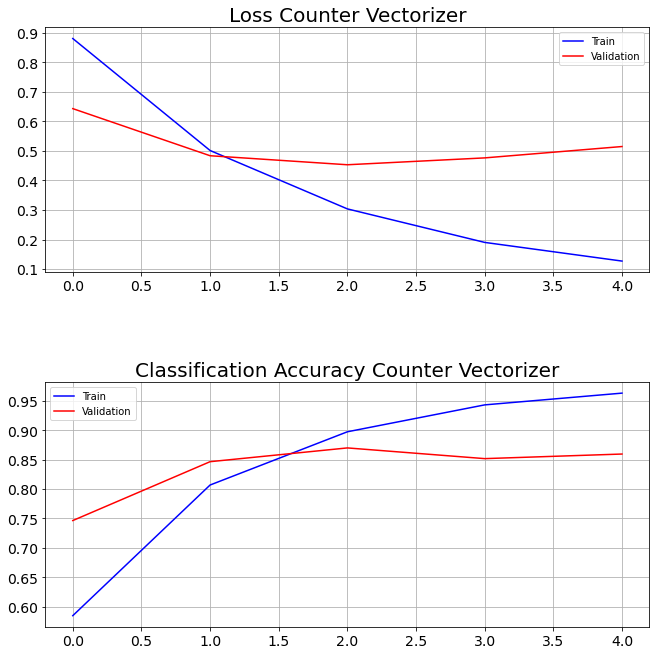

In [82]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 1, 1)
plt.grid()
plt.plot(train_loss, color='blue', label='Train')
plt.plot(val_loss, color='red', label='Validation')
plt.legend()
plt.title('Loss Counter Vectorizer', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Loss_CounterVectorizer.png", dpi=200, bbox_inches='tight')


fig.add_subplot(2, 1, 2)
plt.grid()
plt.plot(train_acc, color='blue', label='Train')
plt.plot(valid_acc, color='red', label='Validation')
plt.legend()
plt.title('Classification Accuracy Counter Vectorizer', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Classifier_Accuracy_CounterVectorizer.png", dpi=200, bbox_inches='tight')

In [83]:
evaluate = model.evaluate(x_test,y_test)

809/809 [==============================] - 0s 65us/step


In [84]:
print("Test Acuracy is : {:.2f} %".format(evaluate[1]*100))
print("Test Loss is : {:.4f}".format(evaluate[0]))

Test Acuracy is : 86.90 %
Test Loss is : 0.4434


In [85]:
predictions = model.predict(x_test)

In [86]:
predict = []
for i in predictions:
    predict.append(np.argmax(i))

In [87]:
cm = confusion_matrix(predict,y_test)
acc = accuracy_score(predict,y_test)

In [88]:
print("The Confusion matrix is: \n",cm)

The Confusion matrix is: 
 [[ 82  16  12]
 [ 21 363  15]
 [ 27  15 258]]


In [89]:
print(acc*100)

86.89740420271941


In [90]:
print(metrics.classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.75      0.63      0.68       130
           1       0.91      0.92      0.92       394
           2       0.86      0.91      0.88       285

    accuracy                           0.87       809
   macro avg       0.84      0.82      0.83       809
weighted avg       0.87      0.87      0.87       809



# Machine Learning for TF_IDF
## TF-IDF Features

In [91]:
train_tfidf = tfidf[:16180,:]

x_train,x_test,y_train,y_test = train_test_split(train_tfidf, combi['sentiment'], random_state=42, test_size=0.3) 

xtrain_tfidf = train_tfidf[y_train.index]
xvalid_tfidf = train_tfidf[y_test.index]

## SVC

In [92]:
svc_model = LinearSVC(class_weight='balanced',C=1, penalty='l2', max_iter=1500,loss='squared_hinge',
                        multi_class='ovr').fit(x_train, y_train)

svc_model_predict = svc_model.predict(x_test)
svc_report = classification_report(y_test, svc_model_predict )

print(svc_report)

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       769
           1       0.79      0.89      0.83      2403
           2       0.86      0.75      0.80      1682

    accuracy                           0.78      4854
   macro avg       0.74      0.71      0.72      4854
weighted avg       0.78      0.78      0.77      4854



## SGD Classifier

In [93]:
sgd_model = SGDClassifier(n_jobs=-1,class_weight='balanced',penalty='l2').fit(x_train, y_train)
sgd_model_predict = sgd_model.predict(x_test)
sgd_report = classification_report(y_test, sgd_model_predict )

print(sgd_report)

              precision    recall  f1-score   support

           0       0.64      0.47      0.54       769
           1       0.77      0.93      0.84      2403
           2       0.89      0.73      0.80      1682

    accuracy                           0.79      4854
   macro avg       0.77      0.71      0.73      4854
weighted avg       0.79      0.79      0.78      4854



## MLP Classifier

In [94]:
mlp = MLPClassifier().fit(x_train, y_train)
mlp_predict = mlp.predict(x_test)
mlp_report = classification_report(y_test, mlp_predict )
print(mlp_report)

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       769
           1       0.79      0.87      0.83      2403
           2       0.82      0.76      0.79      1682

    accuracy                           0.77      4854
   macro avg       0.73      0.71      0.72      4854
weighted avg       0.77      0.77      0.77      4854



D:\Important\Anaconda\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## KNeighbors Classifier

In [95]:
classifier = KNeighborsClassifier(n_neighbors=5,algorithm='brute') 
classifier.fit(x_train, y_train) 
predicted_label = classifier.predict(x_test) 
knn_model_report = classification_report(y_test, predicted_label)
print(knn_model_report)

              precision    recall  f1-score   support

           0       0.50      0.31      0.38       769
           1       0.59      0.90      0.72      2403
           2       0.75      0.32      0.45      1682

    accuracy                           0.61      4854
   macro avg       0.62      0.51      0.52      4854
weighted avg       0.63      0.61      0.57      4854



## Random Forest Classifier

In [96]:
rf = RandomForestClassifier(n_estimators=100).fit(x_train, y_train)
rf_predict = rf.predict(x_test)
rf_report = classification_report(y_test, rf_predict )
print(rf_report)

              precision    recall  f1-score   support

           0       0.74      0.43      0.55       769
           1       0.77      0.93      0.84      2403
           2       0.85      0.76      0.80      1682

    accuracy                           0.79      4854
   macro avg       0.79      0.71      0.73      4854
weighted avg       0.79      0.79      0.78      4854



## AdaBoost Classifier

In [97]:
ab = AdaBoostClassifier(n_estimators=100, learning_rate=1).fit(x_train, y_train)
ab_predict = ab.predict(x_test)
ab_report = classification_report(y_test, ab_predict )
print(ab_report)

              precision    recall  f1-score   support

           0       0.80      0.37      0.51       769
           1       0.71      0.97      0.82      2403
           2       0.90      0.65      0.75      1682

    accuracy                           0.76      4854
   macro avg       0.80      0.66      0.69      4854
weighted avg       0.79      0.76      0.75      4854



## Bagging Classifier

In [98]:
bagging = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(x_train, y_train)
bagging_predict = bagging.predict(x_test)
bagging_report = classification_report(y_test, bagging_predict )
print(bagging_report)

              precision    recall  f1-score   support

           0       0.78      0.41      0.54       769
           1       0.75      0.95      0.84      2403
           2       0.88      0.73      0.80      1682

    accuracy                           0.79      4854
   macro avg       0.80      0.70      0.72      4854
weighted avg       0.80      0.79      0.78      4854



## ExtraTrees Classifier

In [99]:
et = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
et_predict = et.predict(x_test)
et_report = classification_report(y_test, et_predict)
print(et_report)

              precision    recall  f1-score   support

           0       0.72      0.46      0.56       769
           1       0.78      0.92      0.85      2403
           2       0.85      0.78      0.81      1682

    accuracy                           0.80      4854
   macro avg       0.78      0.72      0.74      4854
weighted avg       0.80      0.80      0.79      4854



## DecisionTree Classifier

In [100]:
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
dt_model_report = classification_report(y_test, y_pred)
print(dt_model_report)

              precision    recall  f1-score   support

           0       0.52      0.45      0.49       769
           1       0.77      0.82      0.79      2403
           2       0.76      0.74      0.75      1682

    accuracy                           0.73      4854
   macro avg       0.69      0.67      0.68      4854
weighted avg       0.73      0.73      0.73      4854



## Logistic Regression

In [101]:
logistic_reg_model = LogisticRegression(n_jobs = -1, penalty='l2', multi_class='multinomial',class_weight = 'balanced',verbose=1).fit(x_train,y_train)

lr_model_predict = logistic_reg_model.predict(x_test)
lr_model_report = classification_report(y_test, lr_model_predict)

print(lr_model_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


              precision    recall  f1-score   support

           0       0.46      0.60      0.52       769
           1       0.80      0.82      0.81      2403
           2       0.85      0.70      0.77      1682

    accuracy                           0.74      4854
   macro avg       0.70      0.71      0.70      4854
weighted avg       0.76      0.74      0.75      4854



[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


## Padding and Tokenizing for TF-IDF

In [102]:
num_words = 8000
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words,oov_token = "<oov>" )
tokenizer.fit_on_texts(x)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)
length=[]
for i in sequences:
    length.append(len(i))
print(len(length))
print("Mean is: ",np.mean(length))
print("Max is: ",np.max(length))
print("Min is: ",np.min(length))

16180
Mean is:  12.573609394313968
Max is:  30
Min is:  0


In [103]:
pad_length = 24
sequences = pad_sequences(sequences, maxlen = pad_length, truncating = 'pre', padding = 'post')
sequences.shape

(16180, 24)

In [104]:
x_train,x_test,y_train,y_test = train_test_split(sequences,y,test_size = 0.05)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15371, 24)
(809, 24)
(15371,)
(809,)


## Training Deep Learning Model on Embedding for TF-IDF

In [105]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

model = Sequential([Embedding(num_words, embed_dim, input_length = pad_length),
                   SimpleRNN(8, return_sequences = True),
                   GlobalMaxPool1D(),
                   Dense(20,activation = 'relu',kernel_initializer='he_uniform'),
                   Dropout(0.25),
                   Dense(3,activation = 'softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.name = 'Twitter Hate Text Classification'
model.summary()

Model: "Twitter Hate Text Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 24, 32)            256000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 24, 8)             328       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 256,571
Trainable params: 256,571
Non-trainable params: 0
____________________________

In [106]:
history = model.fit(x = x_train, y = y_train, epochs = 5,validation_split = 0.05)

Train on 14602 samples, validate on 769 samples
Epoch 1/5
14602/14602 [==============================] - 3s 214us/step - loss: 0.8947 - accuracy: 0.5731 - val_loss: 0.6328 - val_accuracy: 0.7568
Epoch 2/5
14602/14602 [==============================] - 3s 195us/step - loss: 0.5069 - accuracy: 0.8158 - val_loss: 0.4471 - val_accuracy: 0.8336
Epoch 3/5
14602/14602 [==============================] - 3s 212us/step - loss: 0.2927 - accuracy: 0.9068 - val_loss: 0.4410 - val_accuracy: 0.8440
Epoch 4/5
14602/14602 [==============================] - 3s 194us/step - loss: 0.2004 - accuracy: 0.9393 - val_loss: 0.4641 - val_accuracy: 0.8336
Epoch 5/5
14602/14602 [==============================] - 3s 212us/step - loss: 0.1413 - accuracy: 0.9598 - val_loss: 0.5087 - val_accuracy: 0.8414


In [107]:
train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

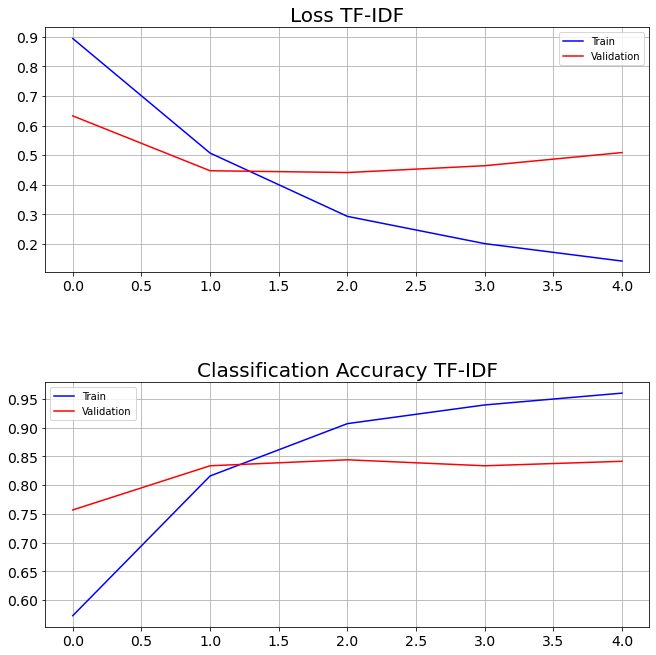

In [108]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 1, 1)
plt.grid()
plt.plot(train_loss, color='blue', label='Train')
plt.plot(val_loss, color='red', label='Validation')
plt.legend()
plt.title('Loss TF-IDF', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Loss_TF_IDF.png", dpi=200, bbox_inches='tight')


fig.add_subplot(2, 1, 2)
plt.grid()
plt.plot(train_acc, color='blue', label='Train')
plt.plot(valid_acc, color='red', label='Validation')
plt.legend()
plt.title('Classification Accuracy TF-IDF', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Classifier_Accuracy_TF_IDF.png", dpi=200, bbox_inches='tight')

In [109]:
evaluate = model.evaluate(x_test,y_test)
print("Test Acuracy is : {:.2f} %".format(evaluate[1]*100))
print("Test Loss is : {:.4f}".format(evaluate[0]))
predictions = model.predict(x_test)
predict = []
for i in predictions:
    predict.append(np.argmax(i))
    
cm = confusion_matrix(predict,y_test)
acc = accuracy_score(predict,y_test)

print("The Confusion matrix is: \n",cm)
print(acc*100)
print(metrics.classification_report(y_test, predict))

809/809 [==============================] - 0s 66us/step
Test Acuracy is : 86.03 %
Test Loss is : 0.4440
The Confusion matrix is: 
 [[ 61   6  10]
 [ 26 356  39]
 [ 18  14 279]]
86.03213844252163
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       105
           1       0.85      0.95      0.89       376
           2       0.90      0.85      0.87       328

    accuracy                           0.86       809
   macro avg       0.84      0.79      0.81       809
weighted avg       0.86      0.86      0.86       809



# Machine learning for Word2Vec
## Word2vec Features

In [110]:
train_w2v = wordvec_df.iloc[:16180,:]
x_train,x_test,y_train,y_test = train_test_split(train_w2v, combi['sentiment'], random_state=42, test_size=0.3)
xtrain_w2v = train_w2v.iloc[y_train.index,:]
xvalid_w2v = train_w2v.iloc[y_test.index,:]

## SVC

In [111]:
svc_model = LinearSVC(class_weight='balanced',C=1, penalty='l2', max_iter=1500,loss='squared_hinge',
                        multi_class='ovr').fit(x_train, y_train)

svc_model_predict = svc_model.predict(x_test)
svc_report = classification_report(y_test, svc_model_predict )

print(svc_report)

              precision    recall  f1-score   support

           0       0.47      0.52      0.50       769
           1       0.74      0.74      0.74      2403
           2       0.68      0.64      0.66      1682

    accuracy                           0.67      4854
   macro avg       0.63      0.64      0.63      4854
weighted avg       0.68      0.67      0.67      4854



## SGD Classifier

In [112]:
sgd_model = SGDClassifier(n_jobs=-1,class_weight='balanced',penalty='l2').fit(x_train, y_train)
sgd_model_predict = sgd_model.predict(x_test)
sgd_report = classification_report(y_test, sgd_model_predict )

print(sgd_report)

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       769
           1       0.68      0.82      0.74      2403
           2       0.70      0.53      0.61      1682

    accuracy                           0.66      4854
   macro avg       0.63      0.59      0.60      4854
weighted avg       0.66      0.66      0.65      4854



## MLP Classifier

In [113]:
mlp = MLPClassifier().fit(x_train, y_train)
mlp_predict = mlp.predict(x_test)
mlp_report = classification_report(y_test, mlp_predict )
print(mlp_report)

              precision    recall  f1-score   support

           0       0.57      0.52      0.54       769
           1       0.78      0.82      0.80      2403
           2       0.73      0.70      0.72      1682

    accuracy                           0.73      4854
   macro avg       0.69      0.68      0.69      4854
weighted avg       0.73      0.73      0.73      4854



D:\Important\Anaconda\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## KNeighbors Classifier

In [114]:
classifier = KNeighborsClassifier(n_neighbors=5,algorithm='brute') 
classifier.fit(x_train, y_train) 
predicted_label = classifier.predict(x_test) 
knn_model_report = classification_report(y_test, predicted_label)
print(knn_model_report)

              precision    recall  f1-score   support

           0       0.44      0.46      0.45       769
           1       0.71      0.72      0.71      2403
           2       0.60      0.58      0.59      1682

    accuracy                           0.63      4854
   macro avg       0.58      0.58      0.58      4854
weighted avg       0.63      0.63      0.63      4854



## RandomForest Classifier

In [115]:
rf = RandomForestClassifier(n_estimators=100).fit(x_train, y_train)
rf_predict = rf.predict(x_test)
rf_report = classification_report(y_test, rf_predict )
print(rf_report)

              precision    recall  f1-score   support

           0       0.82      0.25      0.39       769
           1       0.69      0.84      0.76      2403
           2       0.63      0.62      0.62      1682

    accuracy                           0.67      4854
   macro avg       0.71      0.57      0.59      4854
weighted avg       0.69      0.67      0.65      4854



## AdaBoost Classifier

In [116]:
ab = AdaBoostClassifier(n_estimators=100, learning_rate=1).fit(x_train, y_train)
ab_predict = ab.predict(x_test)
ab_report = classification_report(y_test, ab_predict )
print(ab_report)

              precision    recall  f1-score   support

           0       0.48      0.35      0.40       769
           1       0.69      0.71      0.70      2403
           2       0.56      0.60      0.58      1682

    accuracy                           0.61      4854
   macro avg       0.57      0.55      0.56      4854
weighted avg       0.61      0.61      0.61      4854



## Bagging Classifier

In [117]:
bagging = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(x_train, y_train)
bagging_predict = bagging.predict(x_test)
bagging_report = classification_report(y_test, bagging_predict )
print(bagging_report)

              precision    recall  f1-score   support

           0       0.69      0.37      0.48       769
           1       0.73      0.88      0.80      2403
           2       0.73      0.67      0.70      1682

    accuracy                           0.72      4854
   macro avg       0.71      0.64      0.66      4854
weighted avg       0.72      0.72      0.71      4854



## ExtraTrees Classifier

In [118]:
et = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
et_predict = et.predict(x_test)
et_report = classification_report(y_test, et_predict)
print(et_report)

              precision    recall  f1-score   support

           0       0.83      0.25      0.39       769
           1       0.70      0.84      0.76      2403
           2       0.62      0.64      0.63      1682

    accuracy                           0.68      4854
   macro avg       0.72      0.58      0.59      4854
weighted avg       0.69      0.68      0.66      4854



## DecisionTree Classifier

In [119]:
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
dt_model_report = classification_report(y_test, y_pred)
print(dt_model_report)

              precision    recall  f1-score   support

           0       0.34      0.35      0.34       769
           1       0.63      0.61      0.62      2403
           2       0.50      0.52      0.51      1682

    accuracy                           0.54      4854
   macro avg       0.49      0.49      0.49      4854
weighted avg       0.54      0.54      0.54      4854



## Logistic Regression

In [120]:
logistic_reg_model = LogisticRegression(n_jobs = -1, penalty='l2', multi_class='multinomial',class_weight = 'balanced',verbose=1).fit(x_train,y_train)

lr_model_predict = logistic_reg_model.predict(x_test)
lr_model_report = classification_report(y_test, lr_model_predict)

print(lr_model_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.1s finished


              precision    recall  f1-score   support

           0       0.39      0.63      0.48       769
           1       0.76      0.65      0.70      2403
           2       0.64      0.60      0.62      1682

    accuracy                           0.63      4854
   macro avg       0.60      0.63      0.60      4854
weighted avg       0.66      0.63      0.64      4854



## Padding and Tokenization for Word2Vec

In [121]:
num_words = 8000
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words,oov_token = "<oov>" )
tokenizer.fit_on_texts(x)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)
length=[]
for i in sequences:
    length.append(len(i))
print(len(length))
print("Mean is: ",np.mean(length))
print("Max is: ",np.max(length))
print("Min is: ",np.min(length))

16180
Mean is:  12.573609394313968
Max is:  30
Min is:  0


In [122]:
pad_length = 24
sequences = pad_sequences(sequences, maxlen = pad_length, truncating = 'pre', padding = 'post')
sequences.shape

x_train,x_test,y_train,y_test = train_test_split(sequences,y,test_size = 0.05)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(15371, 24)
(809, 24)
(15371,)
(809,)


## Training Deep Learning Model on Embeddings for Word2vec

In [123]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

model = Sequential([Embedding(num_words, embed_dim, input_length = pad_length),
                   SimpleRNN(8, return_sequences = True),
                   GlobalMaxPool1D(),
                   Dense(20,activation = 'relu',kernel_initializer='he_uniform'),
                   Dropout(0.25),
                   Dense(3,activation = 'softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.name = 'Twitter Hate Text Classification'
model.summary()

Model: "Twitter Hate Text Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 24, 32)            256000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 24, 8)             328       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 63        
Total params: 256,571
Trainable params: 256,571
Non-trainable params: 0
____________________________

In [124]:
history = model.fit(x = x_train, y = y_train, epochs = 5,validation_split = 0.05)

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Train on 14602 samples, validate on 769 samples
Epoch 1/5
14602/14602 [==============================] - 3s 212us/step - loss: 0.8970 - accuracy: 0.5984 - val_loss: 0.7018 - val_accuracy: 0.7100
Epoch 2/5
14602/14602 [==============================] - 3s 207us/step - loss: 0.5877 - accuracy: 0.7689 - val_loss: 0.5581 - val_accuracy: 0.7698
Epoch 3/5
14602/14602 [==============================] - 3s 196us/step - loss: 0.4230 - accuracy: 0.8271 - val_loss: 0.5071 - val_accuracy: 0.7841
Epoch 4/5
14602/14602 [==============================] - 3s 218us/step - loss: 0.3275 - accuracy: 0.8812 - val_loss: 0.4716 - val_accuracy: 0.8231
Epoch 5/5
14602/14602 [==============================] - 3s 199us/step - loss: 0.2579 - accuracy: 0.9162 - val_loss: 0.4595 - val_accuracy: 0.8309


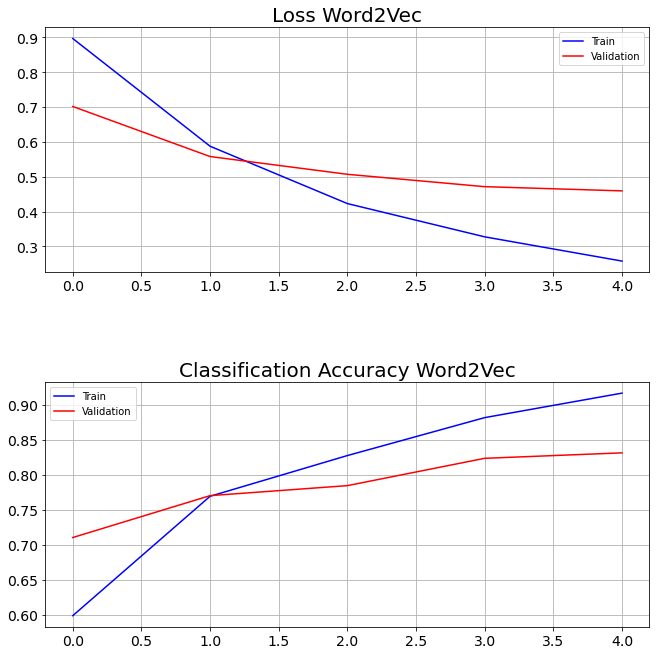

In [125]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 1, 1)
plt.grid()
plt.plot(train_loss, color='blue', label='Train')
plt.plot(val_loss, color='red', label='Validation')
plt.legend()
plt.title('Loss Word2Vec', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Loss_Word2Vec.png", dpi=200, bbox_inches='tight')


fig.add_subplot(2, 1, 2)
plt.grid()
plt.plot(train_acc, color='blue', label='Train')
plt.plot(valid_acc, color='red', label='Validation')
plt.legend()
plt.title('Classification Accuracy Word2Vec', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Classifier_Accuracy_Word2Vec.png", dpi=200, bbox_inches='tight')

In [126]:
evaluate = model.evaluate(x_test,y_test)
print("Test Acuracy is : {:.2f} %".format(evaluate[1]*100))
print("Test Loss is : {:.4f}".format(evaluate[0]))
predictions = model.predict(x_test)
predict = []
for i in predictions:
    predict.append(np.argmax(i))
    
cm = confusion_matrix(predict,y_test)
acc = accuracy_score(predict,y_test)

print("The Confusion matrix is: \n",cm)
print(acc*100)
print(metrics.classification_report(y_test, predict))

809/809 [==============================] - 0s 45us/step
Test Acuracy is : 81.83 %
Test Loss is : 0.5470
The Confusion matrix is: 
 [[ 60  37  22]
 [ 23 355  16]
 [ 35  14 247]]
81.82941903584673
              precision    recall  f1-score   support

           0       0.50      0.51      0.51       118
           1       0.90      0.87      0.89       406
           2       0.83      0.87      0.85       285

    accuracy                           0.82       809
   macro avg       0.75      0.75      0.75       809
weighted avg       0.82      0.82      0.82       809



# Machine Learning for Doc2Vec
## Doc2Vec Features

In [127]:
train_d2v = docvec_df.iloc[:16180,:]
x_train,x_test,y_train,y_test = train_test_split(train_d2v, combi['sentiment'], random_state=42, test_size=0.3)
xtrain_d2v = train_d2v.iloc[y_train.index,:]
xvalid_d2v = train_d2v.iloc[y_test.index,:]

## SVC

In [128]:
svc_model = LinearSVC(class_weight='balanced',C=1, penalty='l2', max_iter=1500,loss='squared_hinge',
                        multi_class='ovr').fit(x_train, y_train)

svc_model_predict = svc_model.predict(x_test)
svc_report = classification_report(y_test, svc_model_predict )

print(svc_report)

              precision    recall  f1-score   support

           0       0.42      0.37      0.39       769
           1       0.67      0.74      0.70      2403
           2       0.60      0.55      0.57      1682

    accuracy                           0.61      4854
   macro avg       0.57      0.55      0.56      4854
weighted avg       0.61      0.61      0.61      4854



## SGD Classifier

In [129]:
sgd_model = SGDClassifier(n_jobs=-1,class_weight='balanced',penalty='l2').fit(x_train, y_train)
sgd_model_predict = sgd_model.predict(x_test)
sgd_report = classification_report(y_test, sgd_model_predict )

print(sgd_report)

              precision    recall  f1-score   support

           0       0.35      0.39      0.37       769
           1       0.67      0.58      0.62      2403
           2       0.51      0.59      0.55      1682

    accuracy                           0.55      4854
   macro avg       0.51      0.52      0.51      4854
weighted avg       0.56      0.55      0.55      4854



## MLP Classifier

In [130]:
mlp = MLPClassifier().fit(x_train, y_train)
mlp_predict = mlp.predict(x_test)
mlp_report = classification_report(y_test, mlp_predict )
print(mlp_report)

              precision    recall  f1-score   support

           0       0.33      0.31      0.32       769
           1       0.66      0.67      0.67      2403
           2       0.55      0.56      0.55      1682

    accuracy                           0.57      4854
   macro avg       0.51      0.51      0.51      4854
weighted avg       0.57      0.57      0.57      4854



D:\Important\Anaconda\envs\NLP\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## KNeighbors Classifier

In [131]:
classifier = KNeighborsClassifier(n_neighbors=5,algorithm='brute') 
classifier.fit(x_train, y_train) 
predicted_label = classifier.predict(x_test) 
knn_model_report = classification_report(y_test, predicted_label)
print(knn_model_report)

              precision    recall  f1-score   support

           0       0.37      0.24      0.29       769
           1       0.56      0.87      0.68      2403
           2       0.70      0.25      0.37      1682

    accuracy                           0.56      4854
   macro avg       0.54      0.45      0.45      4854
weighted avg       0.58      0.56      0.51      4854



## RandomForest Classifier

In [132]:
rf = RandomForestClassifier(n_estimators=100).fit(x_train, y_train)
rf_predict = rf.predict(x_test)
rf_report = classification_report(y_test, rf_predict )
print(rf_report)

              precision    recall  f1-score   support

           0       0.65      0.03      0.06       769
           1       0.61      0.77      0.68      2403
           2       0.51      0.54      0.53      1682

    accuracy                           0.58      4854
   macro avg       0.59      0.45      0.42      4854
weighted avg       0.58      0.58      0.53      4854



## AdaBoost Classifier

In [133]:
ab = AdaBoostClassifier(n_estimators=100, learning_rate=1).fit(x_train, y_train)
ab_predict = ab.predict(x_test)
ab_report = classification_report(y_test, ab_predict )
print(ab_report)

              precision    recall  f1-score   support

           0       0.38      0.19      0.25       769
           1       0.61      0.74      0.67      2403
           2       0.52      0.48      0.50      1682

    accuracy                           0.56      4854
   macro avg       0.50      0.47      0.47      4854
weighted avg       0.54      0.56      0.54      4854



## Bagging Classifier

In [134]:
bagging = BaggingClassifier(base_estimator=SVC(), n_estimators=10, random_state=0).fit(x_train, y_train)
bagging_predict = bagging.predict(x_test)
bagging_report = classification_report(y_test, bagging_predict )
print(bagging_report)

              precision    recall  f1-score   support

           0       0.56      0.14      0.23       769
           1       0.63      0.84      0.72      2403
           2       0.62      0.54      0.57      1682

    accuracy                           0.62      4854
   macro avg       0.60      0.50      0.51      4854
weighted avg       0.61      0.62      0.59      4854



## ExtraTrees Classifier

In [135]:
et = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)
et_predict = et.predict(x_test)
et_report = classification_report(y_test, et_predict)
print(et_report)

              precision    recall  f1-score   support

           0       0.88      0.03      0.06       769
           1       0.61      0.81      0.69      2403
           2       0.53      0.52      0.53      1682

    accuracy                           0.58      4854
   macro avg       0.67      0.45      0.42      4854
weighted avg       0.62      0.58      0.53      4854



## DecisionTree Classifier

In [136]:
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
dt_model_report = classification_report(y_test, y_pred)
print(dt_model_report)

              precision    recall  f1-score   support

           0       0.23      0.25      0.24       769
           1       0.58      0.55      0.57      2403
           2       0.43      0.44      0.43      1682

    accuracy                           0.47      4854
   macro avg       0.41      0.41      0.41      4854
weighted avg       0.47      0.47      0.47      4854



## Logistic Regression

In [137]:
logistic_reg_model = LogisticRegression(n_jobs = -1, penalty='l2', multi_class='multinomial',class_weight = 'balanced',verbose=1).fit(x_train,y_train)

lr_model_predict = logistic_reg_model.predict(x_test)
lr_model_report = classification_report(y_test, lr_model_predict)

print(lr_model_report)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.6s finished


              precision    recall  f1-score   support

           0       0.32      0.54      0.40       769
           1       0.68      0.56      0.61      2403
           2       0.55      0.52      0.54      1682

    accuracy                           0.54      4854
   macro avg       0.52      0.54      0.52      4854
weighted avg       0.58      0.54      0.55      4854



## Padding and Tokenzation Doc2Feature

In [138]:
num_words = 8000
embed_dim = 32
tokenizer = Tokenizer(num_words=num_words,oov_token = "<oov>" )
tokenizer.fit_on_texts(x)
word_index=tokenizer.word_index
sequences = tokenizer.texts_to_sequences(x)
length=[]
for i in sequences:
    length.append(len(i))
print(len(length))
print("Mean is: ",np.mean(length))
print("Max is: ",np.max(length))
print("Min is: ",np.min(length))

pad_length = 24
sequences = pad_sequences(sequences, maxlen = pad_length, truncating = 'pre', padding = 'post')
sequences.shape

x_train,x_test,y_train,y_test = train_test_split(sequences,y,test_size = 0.05)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

16180
Mean is:  12.573609394313968
Max is:  30
Min is:  0
(15371, 24)
(809, 24)
(15371,)
(809,)


## Training Deep Learning Model on Embeddings Doc2Feature

In [139]:
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()

model = Sequential([Embedding(num_words, embed_dim, input_length = pad_length),
                   SimpleRNN(8, return_sequences = True),
                   GlobalMaxPool1D(),
                   Dense(20,activation = 'relu',kernel_initializer='he_uniform'),
                   Dropout(0.25),
                   Dense(3,activation = 'softmax')])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.name = 'Twitter Hate Text Classification'
model.summary()

Model: "Twitter Hate Text Classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 32)            256000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 24, 8)             328       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 8)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                180       
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 63        
Total params: 256,571
Trainable params: 256,571
Non-trainable params: 0
____________________________

In [140]:
history = model.fit(x = x_train, y = y_train, epochs = 5,validation_split = 0.05)

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Train on 14602 samples, validate on 769 samples
Epoch 1/5
14602/14602 [==============================] - 4s 277us/step - loss: 0.8485 - accuracy: 0.6168 - val_loss: 0.6017 - val_accuracy: 0.7711
Epoch 2/5
14602/14602 [==============================] - 3s 228us/step - loss: 0.4949 - accuracy: 0.8024 - val_loss: 0.4937 - val_accuracy: 0.7893
Epoch 3/5
14602/14602 [==============================] - 3s 208us/step - loss: 0.3318 - accuracy: 0.8812 - val_loss: 0.4712 - val_accuracy: 0.8453
Epoch 4/5
14602/14602 [==============================] - 3s 202us/step - loss: 0.2307 - accuracy: 0.9250 - val_loss: 0.4504 - val_accuracy: 0.8492
Epoch 5/5
14602/14602 [==============================] - 3s 233us/step - loss: 0.1694 - accuracy: 0.9495 - val_loss: 0.4934 - val_accuracy: 0.8583


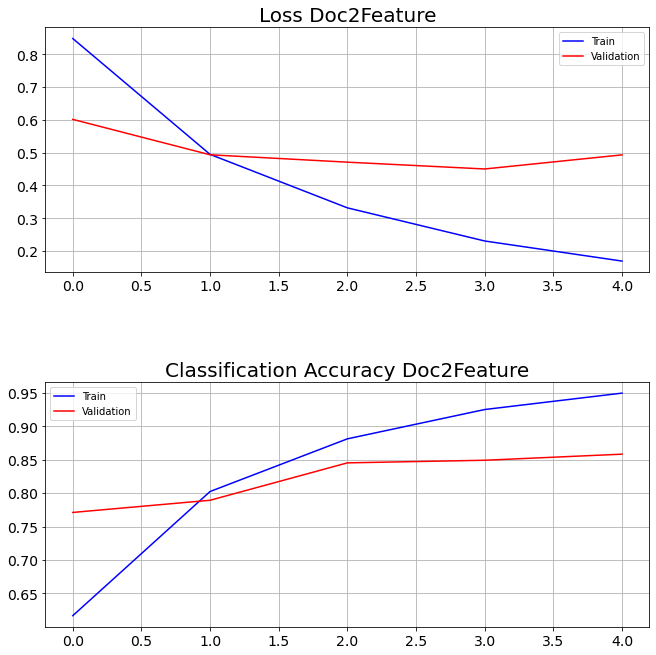

In [141]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 1, 1)
plt.grid()
plt.plot(train_loss, color='blue', label='Train')
plt.plot(val_loss, color='red', label='Validation')
plt.legend()
plt.title('Loss Doc2Feature', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Loss_Doc2Feature.png", dpi=200, bbox_inches='tight')


fig.add_subplot(2, 1, 2)
plt.grid()
plt.plot(train_acc, color='blue', label='Train')
plt.plot(valid_acc, color='red', label='Validation')
plt.legend()
plt.title('Classification Accuracy Doc2Feature', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
fig.savefig("Classifier_Accuracy_Doc2Feature.png", dpi=200, bbox_inches='tight')

In [142]:
evaluate = model.evaluate(x_test,y_test)
print("Test Acuracy is : {:.2f} %".format(evaluate[1]*100))
print("Test Loss is : {:.4f}".format(evaluate[0]))
predictions = model.predict(x_test)
predict = []
for i in predictions:
    predict.append(np.argmax(i))
    
cm = confusion_matrix(predict,y_test)
acc = accuracy_score(predict,y_test)

print("The Confusion matrix is: \n",cm)
print(acc*100)
print(metrics.classification_report(y_test, predict))

809/809 [==============================] - 0s 51us/step
Test Acuracy is : 86.16 %
Test Loss is : 0.4946
The Confusion matrix is: 
 [[ 73   4  10]
 [ 21 360  25]
 [ 35  17 264]]
86.15574783683559
              precision    recall  f1-score   support

           0       0.84      0.57      0.68       129
           1       0.89      0.94      0.91       381
           2       0.84      0.88      0.86       299

    accuracy                           0.86       809
   macro avg       0.85      0.80      0.82       809
weighted avg       0.86      0.86      0.86       809

